# Introduction

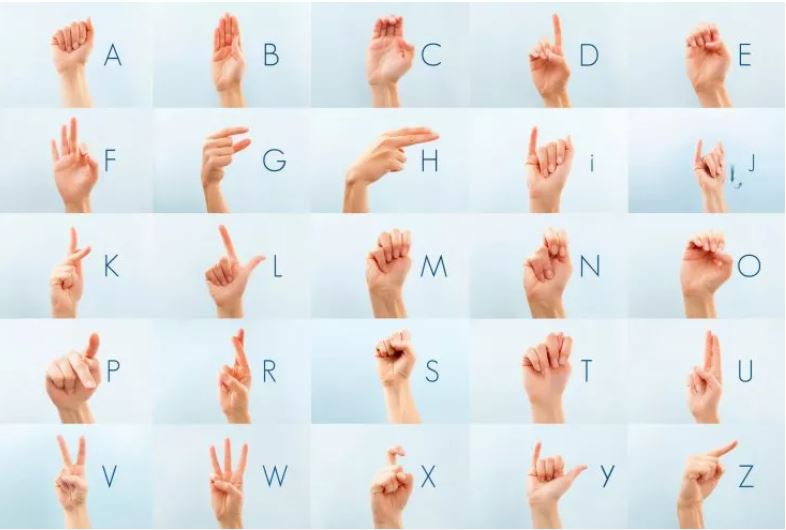

Hello Kagglers!

The below kernel proposes a solution to the popular Sign Language dataset which aims to classify the **American Sign language** images of 24 out of 26 alphabets of English language, using a **Convolutional Neural Network(CNN)** model. The solution uses Keras library of Python to build the model and I have tried to make the notebook as much self explanatory as possible by providing simple codes and easy to implement functions.

A brief description of the problem and the dataset can be found below:
> The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).
> The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.


# Importing libraries and Loading data

In [ ]:
import struct
import random
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from array import array
from os.path  import join
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

While loading the data, we can see from the description that the imported data contains both the predictors and the labels. We hence separate the two(predictors and labels) into different dataframes. Next we drop the labels from the predictor dataframe and check the shapes of the 4 dataframes:

**X_train, X_test, y_train, y_test**

In [ ]:
X_train = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
X_test = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

#Extracting the labels from the data
y_train = X_train["label"]
y_test = X_test["label"]

#Dropping the labels from the X_train and X_test dataframe
X_train.drop(columns = ["label"], inplace = True)
X_test.drop(columns = ["label"], inplace = True)

#Checking the shapes of the dataframes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Data Normalization and Reshaping

A significant step while working with pixeled data is to normalize the dataset so that the original individual values are converted from the range of **[0,255] to [0,1]**. This is a proven step to allow **faster convergence to the global minimum** of the objective function in gradient descent algorithms.


In [ ]:
X_train = X_train/255
X_test = X_test/255

While working with CNN models, we need to ensure that the (input) image data is in the form of (n,n) pixels per channel where the channels represent the RGB channels of a colour filter. Typically, a single channel means a grayscaled image.

In this particular problem, each of the 27,455 images of the input have 784 columns. To feed this data into a CNN model, we will have to *convert the single dimensional data into the CNN accepted data format of 3 dimensions*. Thus, we accomplish this by converting each row of **784 columns into (28,28,1) matrix**.


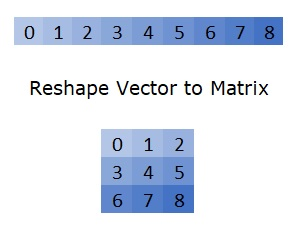

In [ ]:
#Reshaping the data from (m,784) to (m,28,28)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

It might be a good idea to check a random image after all the operations on our input data. In the below line, we are checking the grayscaled image for 108th training example.

In [ ]:
plt.figure(figsize = (2,2))
plt.imshow(X_train[108].reshape(28, 28) , cmap = "gray");

# Data Augmentation

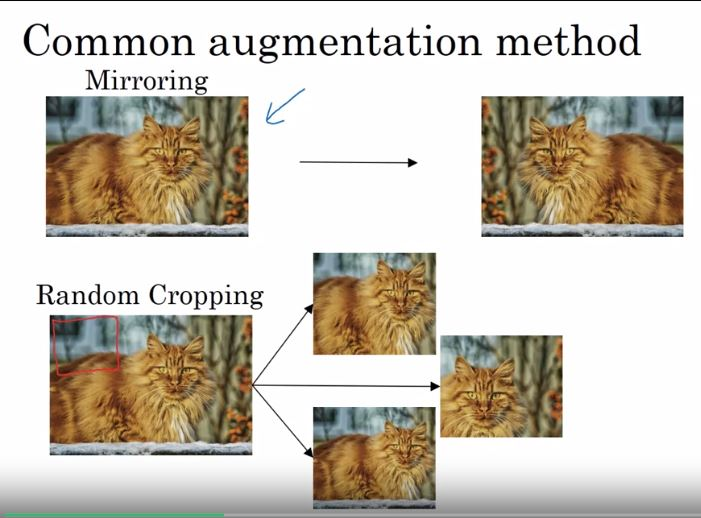

Data augmention involves taking a particular image and generating more images out of it by one of the following methods:
1. **Zooming in**
2. **Zooming out**
3. **Sensible Cropping**
4. **Rotation by a small angle**
5. **Mirroring the image about horizontal or vertical axis**

The effect of augmentation is that we have more variants of the existing training examples and the models generalizes much better over the unseen examples as it has been trained on a quite a variety of input examples. Till date, image augmentation remains one of the best methods to boost the accuracy of any model and hence has widespread applications in image classification problems.

In this particular problem, since we have seen in the introduction section that some images when flipped over in the sign language alphabet become completely different alphabet, *hence to avoid misclassifications, we will not be flipping our images horizontally or vertically*.

In [ ]:
#Augmenting the image data to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# Class Imbalance Detection

Once the input X data is ready in the desired format, we will move our analysis towards the Y labels and check for class imabalance (*if at all it is present*) and treat it accordingly.

Here, we have done a count plot of the 24 classses in our data and find that the data is mostly balanced for all classes.

In [ ]:
plt.figure(figsize = (12,5))
sns.countplot(y_train);

# Model Building

The next step is to build models using a combination of Convolution and Max pooling layers in Keras. We will also be using Batch Normalization and dropout layers to prevent the model from overfitting the data.

In [ ]:
def getCNNModel(shape):
    
    model = Sequential([
        Conv2D(64, (3,3), strides = 1, padding = "same", input_shape = shape, activation = "relu"),
        BatchNormalization(),
        MaxPool2D((2,2), strides =2, padding = "same"),
        Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        Dropout(0.2),
        BatchNormalization(),
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        BatchNormalization(),
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Flatten(),
        Dense(512 , activation = 'relu'),
        Dropout(0.3),
        Dense(units = 25 , activation = 'softmax')
    ])
    
    return model

In [ ]:
model = getCNNModel(X_train[0].shape)
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

We will also be using a callback so that during the model fitting stage, if our validation set accuracy does not increase even after 2 (patience level) consecutive epochs then we will alter our learning rate by a factor of 0.5.

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

# Train Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

# Model fitting

In [ ]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (X_val, y_val) , 
                    callbacks = [learning_rate_reduction])

# Model Evaluation

In [ ]:
print("Test Accuracy " , model.evaluate(X_test,y_test)[1]*100 , "%")

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
dfConfMat = pd.DataFrame(confusion_matrix(y_test,y_pred))
plt.figure(figsize = (15,15))
sns.heatmap(dfConfMat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='');

# Conclusion

Hence, this is how we have achieved, a pretty good accuracy by using 3 sequential combinations of Convolution and Max pooling layers interspersed with Dropout layers and ultimately followed by Dense layers.

I hope that this notebook gave you an insight into incorporating Data Augmentation into your projects. Do give it a try in your notebooks and observe the accuracy shoot up. Moreover, do write back in the comments if you have any doubts in this kernel and would want me to explain something in more detail.

Last but not the least, credit goes to [this](https://www.kaggle.com/madz2000/cnn-using-keras-100-accuracy) notebook for helping out with the data augmentation section.